In [36]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

RAW_MULTISUN = "raw_multisun_csv"
RAW_DARK = "raw_dark_csv"

In [37]:
def parse_name(fname):
    name = fname.lower()
    dev = re.search(r"device\d+", name)
    dev = dev.group() if dev else None

    if "dark" in name:
        inten = "dark"
    else:
        m = re.search(r"\d+p\d+sun", name)
        inten = m.group() if m else None

    scan = "LIV1" if "liv1" in name else "LIV2"
    return dev, inten, scan

In [38]:
def load_folder(folder):
    recs = []
    for f in os.listdir(folder):
        if not f.endswith(".csv"):
            continue
        dev, inten, scan = parse_name(f)
        if dev is None:
            continue

        df = pd.read_csv(os.path.join(folder, f))
        df["V"] = pd.to_numeric(df["V"], errors="coerce")
        df["J"] = pd.to_numeric(df["J"], errors="coerce")
        df = df.dropna(subset=["V", "J"])

        df["Device"] = dev
        df["Intensity"] = inten
        df["Scan"] = scan
        recs.append(df)

    return pd.concat(recs, ignore_index=True)

multi = load_folder(RAW_MULTISUN)
dark = load_folder(RAW_DARK)
alljv = pd.concat([multi, dark], ignore_index=True)

print("Total JV points:", len(alljv))

Total JV points: 26592


In [39]:
def extract_jv_features(df):
    df = df.sort_values("V")
    V = df["V"].values
    J = df["J"].values

    # Jsc at V=0
    Jsc = np.interp(0, V, J)

    # Voc where J=0
    Voc = np.interp(0, J[::-1], V[::-1])

    P = V * J
    Pmax = np.nanmin(P)
    FF = abs(Pmax / (Voc * Jsc)) if Voc != 0 and Jsc != 0 else np.nan

    return Voc, Jsc, FF

In [40]:
def extract_dark_features(df):
    df = df.sort_values("V")
    V = df["V"].values
    J = df["J"].values

    mask = V < 0
    if np.sum(mask) < 5:
        return np.nan, np.nan

    slope, _, _, _, _ = linregress(V[mask], J[mask])
    J0 = J[np.argmin(np.abs(V))]

    return slope, J0

In [41]:
rows = []

for (dev, inten, scan), g in alljv.groupby(["Device", "Intensity", "Scan"]):
    if inten == "dark":
        slope, J0 = extract_dark_features(g)
        rows.append({"Device": dev, "Intensity": "dark", "Scan": scan,
                     "leakage_slope": slope, "J0": J0})
    else:
        Voc, Jsc, FF = extract_jv_features(g)
        rows.append({"Device": dev, "Intensity": inten, "Scan": scan,
                     "Voc": Voc, "Jsc": Jsc, "FF": FF})

features = pd.DataFrame(rows)
features.head()

,Device,Intensity,Scan,Voc,Jsc,FF,leakage_slope,J0
0,device001,0p1sun,LIV1,0.951658,1.488603,33.508829,NaN,NaN
1,device001,0p1sun,LIV2,1.019527,1.523266,26.992897,NaN,NaN
2,device001,0p2sun,LIV1,1.039135,3.031027,11.600383,NaN,NaN
3,device001,0p2sun,LIV2,1.027123,3.138867,11.507008,NaN,NaN
4,device001,0p3sun,LIV1,1.051050,5.183460,7.658821,NaN,NaN


In [42]:
light = features[features["Intensity"] != "dark"].copy()
darkf = features[features["Intensity"] == "dark"].copy()

light["Sun"] = light["Intensity"].str.replace("sun","").str.replace("p",".").astype(float)

light_agg = light.groupby("Device").agg({
    "Voc": ["mean","std","max"],
    "Jsc": ["mean","max"],
    "FF": ["mean","std"]
})
light_agg.columns = ["_".join(c) for c in light_agg.columns]
light_agg = light_agg.reset_index()

dark_agg = darkf.groupby("Device").agg({
    "leakage_slope":"mean",
    "J0":"mean"
}).reset_index()

device_features = pd.merge(light_agg, dark_agg, on="Device", how="left")
device_features.head()

,Device,Voc_mean,Voc_std,Voc_max,Jsc_mean,Jsc_max,FF_mean,FF_std,leakage_slope,J0
0,device001,1.042646,0.173276,1.127335,10.212244,19.870644,7.345626,8.755633,-0.989608,-0.029941
1,device003,1.044688,0.045544,1.080850,11.077374,22.156709,11.192192,11.659431,-0.693089,0.008253
2,device004,1.052900,0.037095,1.110650,10.842081,22.089475,8.037565,9.003439,-0.003212,0.002864


In [43]:
device_features = device_features[
    device_features["Voc_mean"].notna() &
    device_features["Jsc_mean"].notna() &
    device_features["FF_mean"].notna()
]

print("Devices remaining:", len(device_features))
device_features.head()

Devices remaining: 3


,Device,Voc_mean,Voc_std,Voc_max,Jsc_mean,Jsc_max,FF_mean,FF_std,leakage_slope,J0
0,device001,1.042646,0.173276,1.127335,10.212244,19.870644,7.345626,8.755633,-0.989608,-0.029941
1,device003,1.044688,0.045544,1.080850,11.077374,22.156709,11.192192,11.659431,-0.693089,0.008253
2,device004,1.052900,0.037095,1.110650,10.842081,22.089475,8.037565,9.003439,-0.003212,0.002864


In [44]:

device_ids = device_features["Device"].values

X = device_features.drop(columns=["Device"])
X = X.select_dtypes(include=[np.number])
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print("Rows in X:", len(X))

scaler = StandardScaler()
X_scaled_vals = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled_vals, columns=X.columns)
X_scaled["Device"] = device_ids
X_scaled.head()

Rows in X: 3


,Voc_mean,Voc_std,Voc_max,Jsc_mean,Jsc_max,FF_mean,FF_std,leakage_slope,J0,Device
0,-0.924900,1.412045,1.095125,-1.364424,-1.413741,-0.903617,-0.799278,-1.034868,-1.402144,device001
1,-0.464059,-0.638216,-1.322498,1.004331,0.738520,1.393938,1.410018,-0.317303,0.860738,device003
2,1.388960,-0.773829,0.227373,0.360093,0.675221,-0.490321,-0.610740,1.352171,0.541406,device004


In [45]:
kmeans = KMeans(n_clusters=3, random_state=42)
device_features["Cluster"] = kmeans.fit_predict(X_scaled.drop(columns=["Device"]))
device_features[["Device","Cluster"]].head()

d:\Anaconda3\envs\perovAI\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Device,Cluster
0,device001,1
1,device003,0
2,device004,2


In [46]:
device_features.groupby("Cluster").mean(numeric_only=True)

,Voc_mean,Voc_std,Voc_max,Jsc_mean,Jsc_max,FF_mean,FF_std,leakage_slope,J0
Cluster,,,,,,,,,
0,1.044688,0.045544,1.080850,11.077374,22.156709,11.192192,11.659431,-0.693089,0.008253
1,1.042646,0.173276,1.127335,10.212244,19.870644,7.345626,8.755633,-0.989608,-0.029941
2,1.052900,0.037095,1.110650,10.842081,22.089475,8.037565,9.003439,-0.003212,0.002864


In [47]:
os.makedirs("datasets", exist_ok=True)
device_features.to_csv("datasets/week06_device_features.csv", index=False)
print("Saved → datasets/week06_device_features.csv")

Saved → datasets/week06_device_features.csv


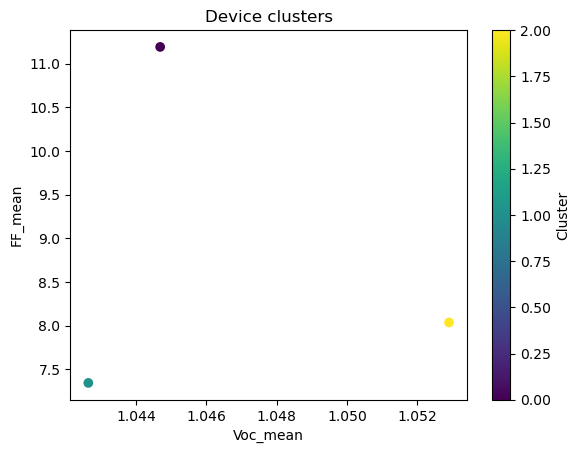

In [48]:
plt.scatter(device_features["Voc_mean"], device_features["FF_mean"],
            c=device_features["Cluster"], cmap="viridis")
plt.xlabel("Voc_mean")
plt.ylabel("FF_mean")
plt.title("Device clusters")
plt.colorbar(label="Cluster")
plt.show()